# Explore Bias

In this notebook the operators $T$ and $T^*$, and it's influence over the signals and noise are analysed. The original signal is attempted to be recovered simply with the pseudoinverse of $T^*T$ in the same way as the bias term and the initial guess are obtaied.

In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

## Create model

In [2]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 1,
    'r' : 1

}

In [3]:
# Model
model = FBRestNet(
    experimentation=Physics(params['N'],params['k'],params['a'],params['r']), constraint = 'cube', nb_blocks=20, noise = 0.05,
    folder = './../', im_set="Set1",batch_size=[600,1],lr=1e-3, nb_epochs=[30,1], save=False
)

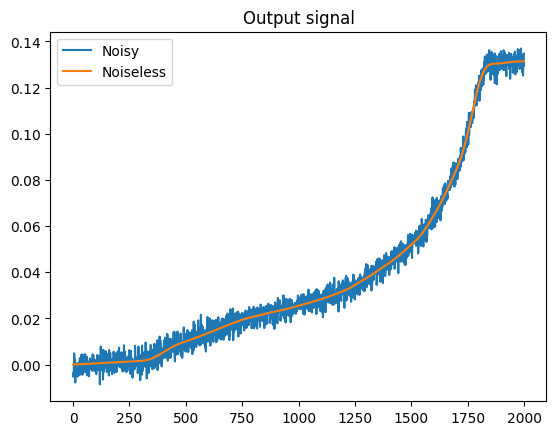

In [4]:
# Generate dataset
train_set, val_set = model.CreateDataSet()

## Prepare signal

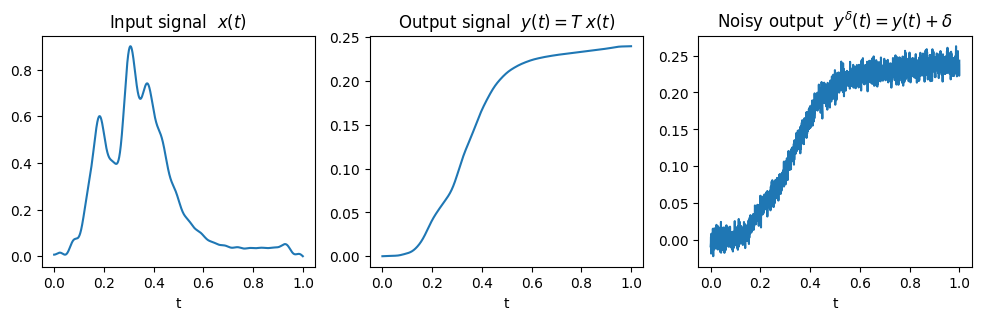

In [6]:
# Select one signal
signal_id = 6
[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

# Input signal in the finite elements basis
test_signal_coeff = np.array(x_true[0,0])
test_signal_elt = torch.Tensor(model.physics.basis.T @ test_signal_coeff * params['N'])

# Output signal with noise
y =  model.physics.Compute(test_signal_elt)
noise_std_dev = model.noise * np.sqrt((torch.sum(y**2)).item() )/np.sqrt(params['N'])
noise = torch.randn(test_signal_elt.shape) * noise_std_dev
y_noisy = model.physics.Compute(test_signal_elt) + noise

t = np.linspace(0,(params['N']-1)/params['N'],params['N'])
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].plot(t, model.model.Layers[0].Pelt(x_true).numpy()[0,0])
ax[0].set_title(r'Input signal  $x(t)$')
ax[0].set_xlabel('t')
ax[1].plot(t, y)
ax[1].set_title(r'Output signal  $y(t)=T\;x(t)$')
ax[1].set_xlabel('t')
ax[2].plot(t, y_noisy)
ax[2].set_title(r'Noisy output  $y^{\delta}(t)=y(t) + \delta$')
ax[2].set_xlabel('t')
plt.show()

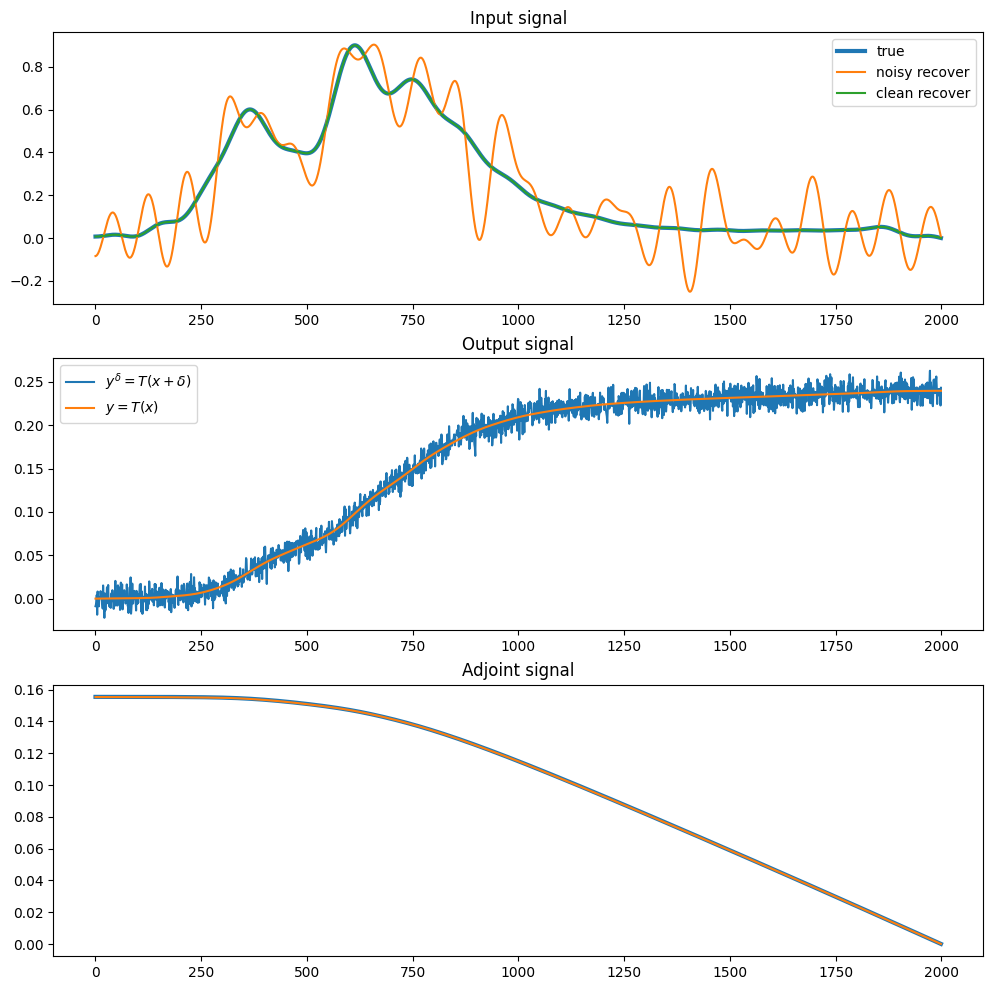

In [9]:

y_noisy_adj = model.physics.BasisChangeInv(model.physics.ComputeAdjoint(y_noisy))
y_adj = model.physics.BasisChangeInv(model.physics.ComputeAdjoint(y))

# T*T inverse
inv      = np.diag(model.physics.eigm**(2*model.physics.a))
tTTinv   = MyMatmul(inv)
x_hat_noisy   = tTTinv(torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y_noisy))))
x_hat   = tTTinv(torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y))))

im, ax = plt.subplots(3,1, figsize=(12,12))
ax[0].plot(test_signal_elt, label='true', linewidth=3)
ax[0].plot(model.physics.BasisChangeInv(x_hat_noisy), label='noisy recover')
ax[0].plot(model.physics.BasisChangeInv(x_hat), label='clean recover')
ax[0].legend()
ax[0].set_title('Input signal')

ax[1].plot(y_noisy, label='$y^{\delta}=T(x+\delta)$')
ax[1].plot(y, label='$y=T(x)$')
ax[1].legend()
ax[1].set_title('Output signal')

ax[2].plot(y_adj,linewidth=3)
ax[2].plot(y_noisy_adj)
ax[2].set_title('Adjoint signal')
plt.show()

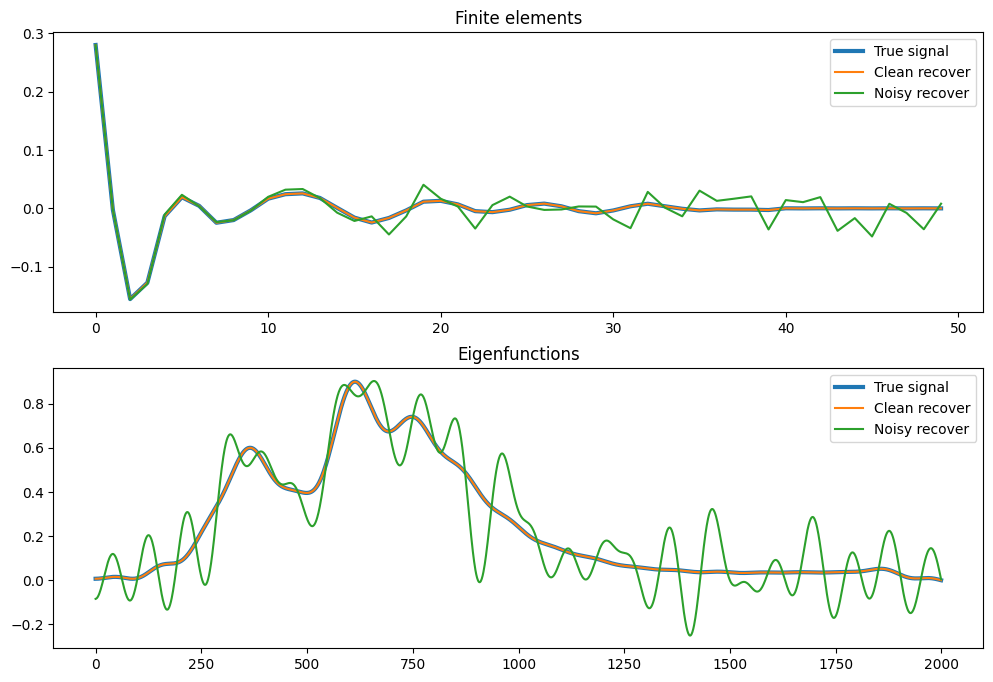

In [8]:
test_signal_eig = x_hat #model.physics.BasisChange(test_signal_elt)
test_signal_eig_noisy = x_hat_noisy
test_signal_elt_recover = model.physics.BasisChangeInv(test_signal_eig)
test_signal_elt_noisy_recover = model.physics.BasisChangeInv(test_signal_eig_noisy)

fig,ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(test_signal_eig, label='True signal', linewidth=3)
ax[0].plot(test_signal_eig, label='Clean recover')
ax[0].plot(test_signal_eig_noisy, label='Noisy recover')
ax[0].set_title('Finite elements')
ax[0].legend()

ax[1].plot(test_signal_elt, label='True signal', linewidth=3)
ax[1].plot(test_signal_elt_recover, label='Clean recover')
ax[1].plot(test_signal_elt_noisy_recover, label='Noisy recover')
ax[1].set_title('Eigenfunctions')
ax[1].legend()
plt.show()